## Build a machine learning model to predict user will click the ad or not based on his experience and estimated salary for a given dataset

### Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import os
os.chdir('/home/admin1/PycharmProjects/Machine Learning using libraries/Classification/Datasets & pickled objects/')
import sys
sys.path.append('/home/admin1/PycharmProjects/Machine Learning using libraries/')
from ipynb.fs.full.ml_library import *

# reading dataset from file & storing it as pandas dataframe
social_network_data = pd.read_csv('Social_Network_Ads.csv')
social_network_data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


#### Using already done preprocessing steps from pickle file

In [2]:
import joblib
file = open('DataProcessingAdClick.pkl', 'rb')
features = joblib.load(file)
label = joblib.load(file)
sc_x = joblib.load(file)
file.close()

#### Separating out feature colums & label column 

In [3]:
x_values = social_network_data.loc[:,features].values
y_values = social_network_data.loc[:,label].values

In [4]:
x_values = sc_x.transform(x_values)

#### Splitting dataset into train set & test set

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
train_x_values, test_x_values, train_y_values, test_y_values = train_test_split(x_values, y_values, train_size=0.8, random_state=20)

### Building Support Vector Machine (SVM) model

In [6]:
from sklearn.svm import SVC

classifier = SVC()

#### Plotting learning curve

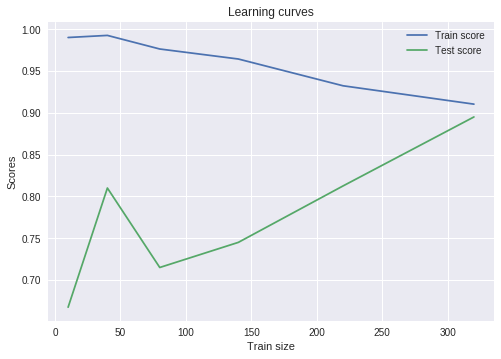

In [7]:
from sklearn.model_selection import learning_curve
# defining different train set sizes
train_sizes= [10,40,80,140,220,320]

# creating x-axis values & y-axis values for learning curve
train_sizes, train_scores, test_scores = learning_curve(estimator=classifier, X=x_values, y=y_values,
                                                        train_sizes=train_sizes, scoring='accuracy', cv=10)
# taking mean for each cross-validation
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean =  test_scores.mean(axis=1)

# plotting two line graphs for different test sizes 
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label='Train score')
plt.plot(train_sizes, test_scores_mean, label='Test score')
plt.xlabel('Train size')
plt.ylabel('Scores')
plt.title('Learning curves')
plt.legend()
plt.show()

In [8]:
# We need whole train set for training of classifier model

#### Setting optimal hyperparametrs using gridsearch

In [9]:
# defining hypermeters in list of dictionaries initially & changing these to optimal values after running this block of code
parameters = [{'C':[.1,.2,.3,.5,.6], 'kernel': ['rbf'], 'gamma':[.1,.2,.3]},
             {'C':[1,10,100,1000], 'kernel': ['linear'], 'gamma':[.1,.01,.001]},
             {'C':[1,10,100,1000], 'kernel': ['poly'], 'gamma':[.1,.01,.001]}]

# creating grid search object with paramters to try & 10-fold cross validation
grid_search = GridSearchCV(estimator=classifier, param_grid=parameters, scoring='accuracy', cv=10)

# fitting classifier model for given parameters for trial
grid_search = grid_search.fit(train_x_values, train_y_values)

# finding best accuracy & best parameters
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
best_accuracy, best_parameters

# unpacking hypermeters' optimal values to variable further will be feed to classifier model
C, gamma, kernel = best_parameters.values()
best_parameters, (C, gamma, kernel)

({'C': 0.3, 'gamma': 0.2, 'kernel': 'rbf'}, (0.3, 0.2, 'rbf'))

#### Setting optimal parameters

In [10]:
classifier = SVC(kernel=kernel, probability=True, C=C, gamma=gamma, random_state=0)
classifier.fit(x_values, y_values)

SVC(C=0.3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
    max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

#### Checking cross-validation scores

In [11]:
accuracies = cross_val_score(estimator=classifier, X=x_values, y=y_values, cv=10)
accuracies, accuracies.mean(), accuracies.std()

(array([0.975, 0.875, 0.9  , 0.975, 1.   , 0.85 , 0.8  , 0.75 , 0.9  ,
        0.925]), 0.8950000000000001, 0.07566372975210778)

#### Storing essential objects into pickle file

In [12]:
import joblib
file = open('SVMModelAdClick.pkl', 'wb')
joblib.dump(classifier, file)
file.close()

#### Storing predictions for test set

In [13]:
test_prediction = classifier.predict(test_x_values)

### Evaluating model against test set 

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
print(f'Confusion matrix:\n {confusion_matrix(test_y_values, test_prediction)}')
print(f'\nClassification report:\n {classification_report(test_y_values, test_prediction)}')

Confusion matrix:
 [[44  1]
 [ 5 30]]

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94        45
           1       0.97      0.86      0.91        35

    accuracy                           0.93        80
   macro avg       0.93      0.92      0.92        80
weighted avg       0.93      0.93      0.92        80



### Plotting colormap for  classification

#### 1 (blue) represents user purchased &  0 (red) represents user not purchased

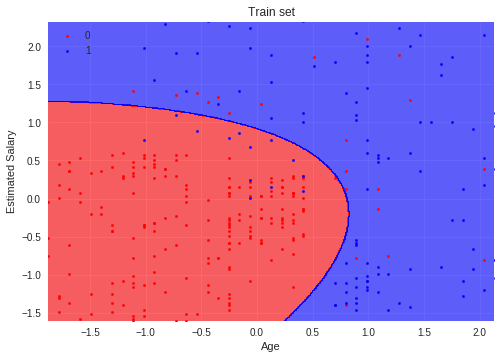

In [15]:
plot_colormap(train_x_values, train_y_values, classifier,'Train set')

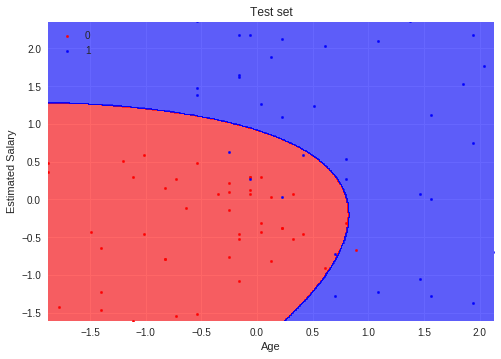

In [16]:
plot_colormap(test_x_values, test_y_values, classifier,'Test set')

### Plotting CAP (Cumulative Accuracy Profile) curve

Accuracy using CAP curve: 0.8571428571428571


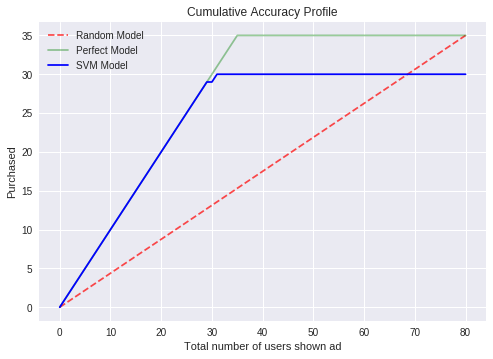

In [17]:
prob = 0.5   # it is default threshold probability for classification in sklearn
plot_cap_curve(test_y_values, test_x_values, classifier, prob, 'Total number of users shown ad', 'Purchased', 'SVM Model')

#### If we want precision in prediction of accurate potential users those will purchase (high precision score)

In [18]:
test_prob = classifier.predict_proba(test_x_values)[:,1]
prob = 0.7
test_prediction = np.where(test_prob > prob, 1, 0)
print(f'Confusion matrix:\n {confusion_matrix(test_y_values, test_prediction)}')
print(f'Classification report:\n {classification_report(test_y_values, test_prediction)}')

Confusion matrix:
 [[45  0]
 [ 7 28]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      1.00      0.93        45
           1       1.00      0.80      0.89        35

    accuracy                           0.91        80
   macro avg       0.93      0.90      0.91        80
weighted avg       0.92      0.91      0.91        80



#### Plotting CAP curve for high precision

Accuracy using CAP curve: 0.8


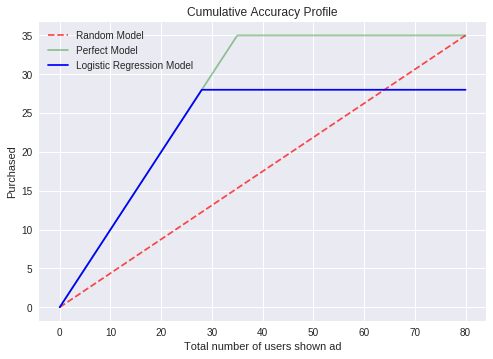

In [19]:
plot_cap_curve(test_y_values, test_x_values, classifier, prob, 'Total number of users shown ad', 'Purchased', 'Logistic Regression Model')

#### If we want to miss out minimum potential user who will purchase (high recall score)

In [20]:
prob = 0.1
test_prediction = np.where(test_prob > prob, 1, 0)
print(f'Confusion matrix:\n {confusion_matrix(test_y_values, test_prediction)}')
print(f'Classification report:\n {classification_report(test_y_values, test_prediction)}')

Confusion matrix:
 [[38  7]
 [ 2 33]]
Classification report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89        45
           1       0.82      0.94      0.88        35

    accuracy                           0.89        80
   macro avg       0.89      0.89      0.89        80
weighted avg       0.90      0.89      0.89        80



#### Plotting CAP curve for high recall

Accuracy using CAP curve: 0.9428571428571428


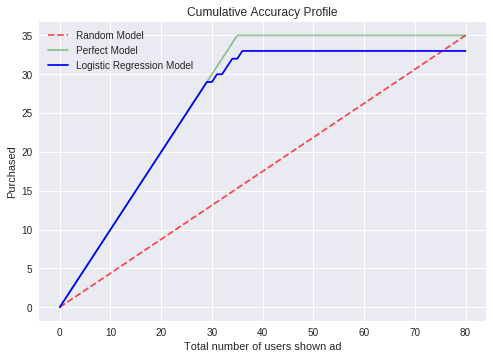

In [21]:
plot_cap_curve(test_y_values, test_x_values, classifier, prob, 'Total number of users shown ad', 'Purchased', 'Logistic Regression Model')

### Plotting ROC curve

In [22]:
# calculating area under curve
def calculate_auc(model, fpr, tpr):
    roc_auc = auc(fpr, tpr)
    print('AUC '+model+':', roc_auc)

AUC SVM: 0.9841269841269842


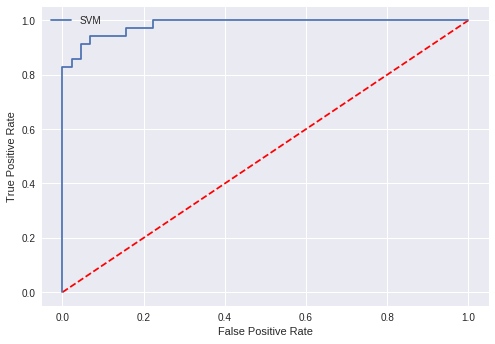

In [23]:
from sklearn.metrics import roc_curve, auc
# finding probability for default class 1
test_predicted_prob_svm = classifier.predict_proba(test_x_values)[:,1]

# getting x-axis & y-axis values 
fpr_svm, tpr_svm, _ = roc_curve(test_y_values, test_predicted_prob_svm)

calculate_auc('SVM', fpr_svm, tpr_svm)
# Plotting ROC curve
plt.plot([0,1],[0,1], 'r--')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

### Comparing different classification models using ROC curve

#### Using pickled objects of different classificationmodels

In [24]:
import joblib
file = open('LogisticModelAdClick.pkl', 'rb')
logistic_classifier = joblib.load(file)
file.close()

file = open('KNNModelAdClick.pkl', 'rb')
KNN_classifier = joblib.load(file)
file.close()

file = open('DCTModelAdClick.pkl', 'rb')
DCT_classifier = joblib.load(file)
file.close()

file = open('RFModelAdClick.pkl', 'rb')
RF_classifier = joblib.load(file)
file.close()

file = open('GaussianNBModelAdClick.pkl', 'rb')
GaussianNB_classifier = joblib.load(file)
file.close()

#### Storing different classification model object in list 

In [25]:
classifiers = [logistic_classifier, KNN_classifier, classifier, DCT_classifier, RF_classifier, GaussianNB_classifier]
classifier_names = ['Logistic', 'KNN', 'SVM', 'DecisionTree', 'RandomForest', 'GaussianNaiveBayes']

AUC Logistic: 0.9726984126984127
AUC KNN: 0.9736507936507937
AUC SVM: 0.9841269841269842
AUC DecisionTree: 0.9882539682539683
AUC RandomForest: 0.9850793650793651
AUC GaussianNaiveBayes: 0.9828571428571428


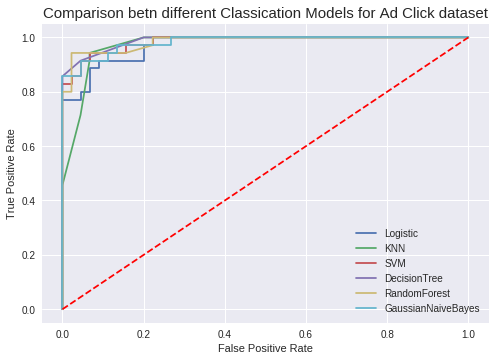

In [26]:
# finding probability for default class 1
    
test_predicted_probs = [classifier.predict_proba(test_x_values)[:,1] for classifier in classifiers]

# Plotting ROC curve & calculating AUCs
for index in range(len(classifiers)):
    fpr, tpr, _ = roc_curve(test_y_values, test_predicted_probs[index])
    calculate_auc(classifier_names[index], fpr, tpr)
    plt.plot(fpr, tpr, label=classifier_names[index])

plt.plot([0,1],[0,1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison betn different Classication Models for Ad Click dataset',fontdict={'fontsize':15})
plt.legend()
plt.show()